# Density Profile and IFT of mixture of Hexane + Ethanol and CPME

First it's needed to import the necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sgtpy import component, mixture, saftvrmie
from sgtpy.equilibrium import bubblePy
from sgtpy.sgt import sgt_mix


The ternary mixture is created and then the interactions parameters are set. As CPME can associate with Ethanol, this site/site interaction are set up manually modifying the ```eos.eABij``` and ```eos.rcij``` arrays. Finally, the $\beta_{ij}$ corrections are set.

In [2]:
ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1], cii= 5.3141080872882285e-20)

cpme = component('cpme', ms =  2.32521144, sigma = 4.13606074, eps = 343.91193798, lambda_r = 14.15484877, 
                 lambda_a = 6.0, npol = 1.91990385,mupol = 1.27, sites =[0,0,1], cii = 3.5213681817448466e-19)

hexane = component('hexane', ms = 1.96720036, sigma = 4.54762477, eps = 377.60127994, 
                   lambda_r = 18.41193194, npol = 0., cii = 3.581510586936205e-19 )

# creating mixture
mix = mixture(hexane, ethanol)
mix.add_component(cpme)

# setting kij corrections
k12 = 0.011818492037463553
k13 = 0.0008700151297528677
k23 =  0.01015194
Kij = np.array([[0., k12, k13], [k12, 0., k23], [k13, k23, 0.]])
mix.kij_saft(Kij)

eos = saftvrmie(mix)

# cross associationg set up 
rc = 2.23153033
eos.eABij[1,2] = ethanol.eAB / 2
eos.eABij[2,1] = ethanol.eAB / 2
eos.rcij[1,2] = rc * 1e-10
eos.rcij[2,1] = rc * 1e-10

# setting beta corrections for SGT
b12 = 0.05719272059410664
b13 = 0.0
b23 = 0.0358453055603665

beta = np.array([[0., b12, b13],
                [b12, 0., b23],
                [b13, b23, 0.]])

eos.beta_sgt(beta)

Now it is necessary to compute the equilibria pressure. This bubble point is computed with the ```bubblePy``` function. Further information about this function can be found running ```bubblePy?```.

In [3]:
# computing bubble points
X = np.array([0.906, 0.071,0.023])
T = 298.15 # K

# initial guesses for pressure and vapor composition
P0 = 20000. # Pa
y0 = np.array([0.7, 0.2, 0.1])

sol  = bubblePy(y0, P0, X, T, eos, full_output = True)
sol

      T: 298.15
      P: 25046.06150944494
  error: 7.325473561081708e-12
   iter: 5
      X: array([0.906, 0.071, 0.023])
     v1: 0.00012629072366908533
  Xassl: array([0.16365061, 0.42830657, 0.85732395])
 state1: 'Liquid'
      Y: array([0.77117555, 0.22352795, 0.0052965 ])
     v2: 0.09772467726138466
  Xassv: array([0.98128651, 0.99061242, 0.99887325])
 state2: 'Vapor'

The results are used to compute the density vectors and the SGT is applied with the ```sgt_mix``` function. Further information about this function can be found running ```sgt_mix?```.

In [4]:
# reading solution object
Y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2

#density vector of each phase
rhox = X/vl
rhoy = Y/vv

In [5]:
solsgt = sgt_mix(rhoy, rhox, T, P, eos, n = 25, full_output = True)

Text(0, 0.5, '$\\rho$ / kmol m$^{-3}$')

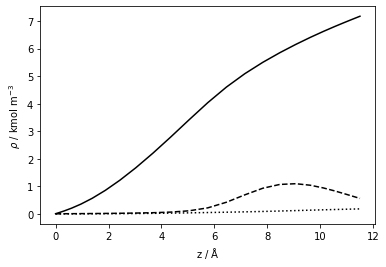

In [6]:
# density paths in kmol/m3
rho = solsgt.rho / 1000
z = solsgt.z # in Amstrong

plt.plot(z, rho[0], color= 'k')
plt.plot(z, rho[1], '--',color = 'k')
plt.plot(z, rho[2], ':', color = 'k')
plt.xlabel(r'z / $\rm \AA$')
plt.ylabel(r'$\rho$ / kmol m$^{-3}$')